In [102]:
# pip install pyabf
import numpy as np
import scipy.io
import pyabf
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
import tkinter as tk
from tkinter import filedialog
import os
import h5py

In [103]:
## Load the recording data and select the part of interest
# line 4
fsSpikes = 50000


root = tk.Tk()
root.withdraw()
root.attributes('-topmost',True)

current_directory = os.getcwd()
file_path = filedialog.askopenfilename(initialdir=current_directory)
_, file_extension = os.path.splitext(file_path)

if file_extension == '.mat':
    mat_data = scipy.io.loadmat(file_path)
    recording1 = mat_data['recording1'].flatten()
    rawsignal = recording1[20 * fsSpikes:260 * fsSpikes]
elif file_extension == '.abf':
    recording1 = pyabf.ABF("30 min_0001.abf")
    start_index = 20 * fsSpikes
    end_index = 260 * fsSpikes
    rawsignal = recording1.sweepY[start_index:end_index]
else:
    print(f"Unsupportedd file type: {file_extension}")



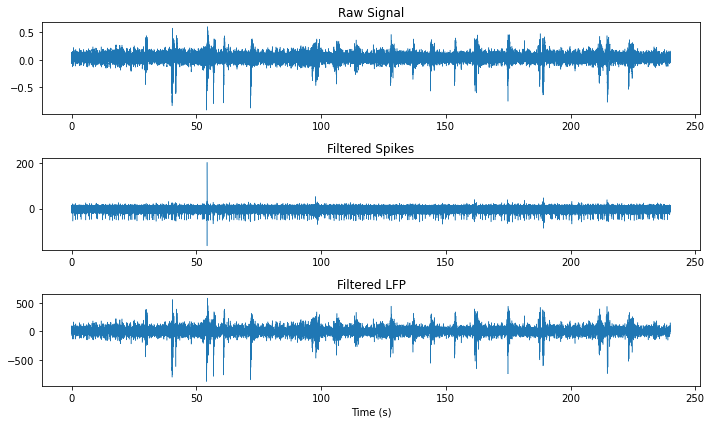

In [104]:
## Bandpass filter for Spikes and LFP
# line 9

Fc1_spikes, Fc2_spikes = 300, 3000
b_spikes, a_spikes = butter(4, [Fc1_spikes, Fc2_spikes], btype='band', fs=fsSpikes)
spikes = filtfilt(b_spikes, a_spikes, rawsignal) * 1000

Fc1_lfp, Fc2_lfp = 0.5, 300
b_lfp, a_lfp = butter(2, [Fc1_lfp, Fc2_lfp], btype='band', fs=fsSpikes)
LFP = filtfilt(b_lfp, a_lfp, rawsignal) * 1000
# Plot
# line 23

time = np.arange(0, len(spikes)) / fsSpikes

plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(time, rawsignal, linewidth=0.5)
plt.title('Raw Signal')
plt.subplot(3, 1, 2)
plt.plot(time, spikes, linewidth=0.5)
plt.title('Filtered Spikes')
plt.subplot(3, 1, 3)
plt.plot(time, LFP, linewidth=0.5)
plt.title('Filtered LFP')

plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

In [105]:
## Detect the spike according to the threshold
# line 33

upper_threshold = -100
threshold = -20

ind_above = np.where(spikes < threshold)[0]
vector = np.zeros_like(spikes)
vector[ind_above] = spikes[ind_above]

above_threshold = ind_above
# 1.5 ms delay in sample numbers
delay = int(fsSpikes / 1000 * 1.5)

end_spike_index = []
n = 1

for ii in range(len(above_threshold) - 1):
    if spikes[above_threshold[ii]] != spikes[above_threshold[ii + 1]] and \
       above_threshold[ii] < above_threshold[ii + 1] - delay:
        end_spike_index.append(above_threshold[ii])
        n += 1

spike_index = []
for ii in range(1, len(end_spike_index)):
    window = spikes[end_spike_index[ii] - delay:end_spike_index[ii] + delay]
    M = np.min(window)
    index = np.argmin(window)
    if M > upper_threshold:
        spike_index.append(end_spike_index[ii] - delay + index)

spike_index = np.array(spike_index)

In [106]:
## Delete the fake oscillation spike
# line 67

deleteEv = []

for i in range(len(spike_index)):
    before = range(spike_index[i] - 51, spike_index[i] - 21, 1)
    after = range(spike_index[i] + 20, spike_index[i] + 50, 1)

    beforeFind = [index for index, val in enumerate(spikes[before]) if val < -10 or val > 25]
    afterFind = [index for index, val in enumerate(spikes[after]) if val < -10 or val > 25]

    if len(beforeFind) > 1 or len(afterFind) > 1:
        deleteEv.append(i)

for i in deleteEv:
    spike_index[i] = 0

spike_index = [element for element in spike_index if element != 0]

In [107]:
## Get the 3 ms spike cutout
# line 82

per = 50
detected_spikes = spike_index
num_spikes = len(detected_spikes)
data = np.zeros((num_spikes, 2 * per))

start = np.zeros(num_spikes, dtype=int)
stop = np.zeros(num_spikes, dtype=int)
starttime = np.zeros(num_spikes, dtype=int)

for i in range(num_spikes):
    start[i] = detected_spikes[i] - per
    stop[i] = start[i] + (2 * per)
    data[i][:] = spikes[start[i]:stop[i]]
    starttime[i] = start[i]

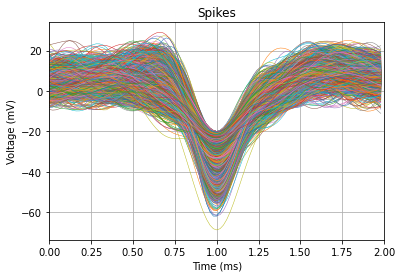

In [108]:
## PCA analysis
# line 95

data = np.array(data)

# Perform PCA on 'data'
pca = PCA(n_components=3)  # Specify the number of components (3 in this case)
# pca = PCA()
coeff = pca.fit_transform(data)
score = pca.components_
ev = pca.explained_variance_

# Calculate the mean of 'data'
mu = np.mean(data, axis=0)

# Select the first 3 principal components
pcadata = coeff[:, :3]

# plot data
time = np.arange(0, 2 * per, 1 / fsSpikes) * 1000

plt.figure()
plt.plot(time[:data.shape[1]], data.T, linewidth = 0.5)
plt.title('Spikes')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.xlim(0, 2 * per * 1000 / fsSpikes)
plt.grid(True)

In [109]:
## line 107

desired_k = 3
kmeans = KMeans(n_clusters=desired_k, init='k-means++', n_init=desired_k + 6, random_state=42)
kmeans.fit(data)
IDX = kmeans.labels_
C = kmeans.cluster_centers_
# Define colors for each cluster
color_cluster = [
    [0.259, 0.62, 0.741],
    [0, 0, 1],
    [1, 0, 1],
    [0.949, 0.498, 0.047],
    [1, 1, 0],
    [0, 1, 1],
    [0.5, 0, 1],
    [0, 0.5, 1],
    [1, 0.5, 0],
    [1, 0, 0.5]
]

Text(0, 0.5, 'Voltage (mV)')

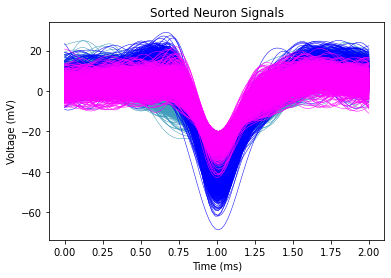

In [110]:
## Plot each cluster
plt.figure()
for i in range(desired_k):
    # Select data for the current cluster
    cluster_data = data[IDX == i, :]
#     # Time vector for plotting
    time = np.linspace(0, (2 * per) * 1e3 / fsSpikes, cluster_data.shape[1])
#     # Plot each waveform in the cluster
    for waveform in cluster_data:
        plt.plot(time, waveform, color=color_cluster[i], linewidth=0.5)

plt.title('Sorted Neuron Signals')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')



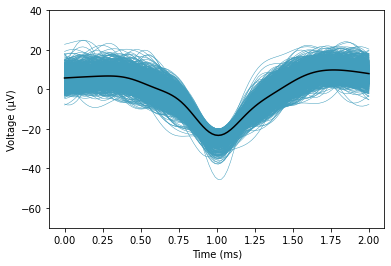

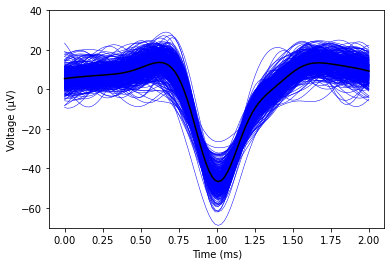

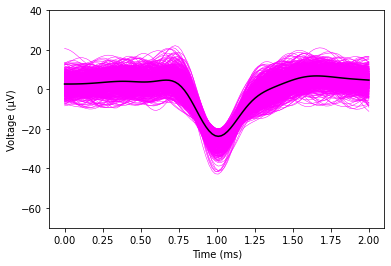

In [111]:
# line 126

for i in range(desired_k):
    plt.figure()
    # Select data for the current cluster
    cluster_data = data[IDX == i, :]
    # Time vector for plotting
    time = np.linspace(0, (2 * per) * 1e3 / fsSpikes, cluster_data.shape[1])
    # Plot each waveform in the cluster
    for waveform in cluster_data:
        plt.plot(time, waveform, color=color_cluster[i], linewidth=0.5)

    # Calculate the mean waveform for the current cluster
    meanofdata = np.mean(cluster_data, axis=0)
    # Plot the mean waveform
    plt.plot(time, meanofdata, 'k', linewidth=1.5)  # 'k' is for black color

    # plt.title(f'Sorted neuron signals cluster={i+1}')  # i+1 to convert from 0-based to 1-based indexing
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (µV)')
    plt.ylim([-70, 40])

plt.show()

# line 141

pca = PCA(n_components=3)  # Adjust the number of components as necessary
# pca = PCA()
pca.fit(data)
coeff = pca.components_
score = pca.transform(data)
ev = pca.explained_variance_



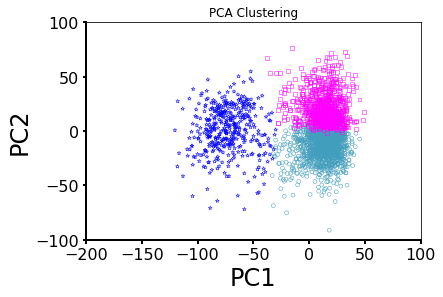

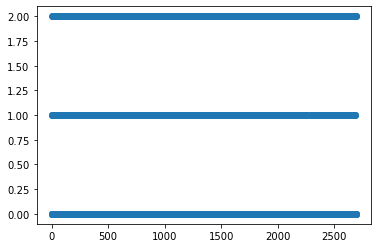

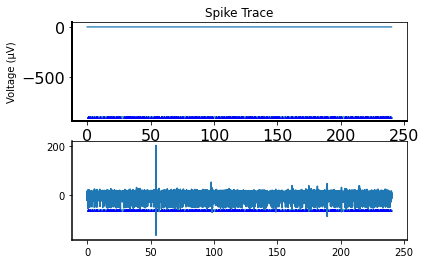

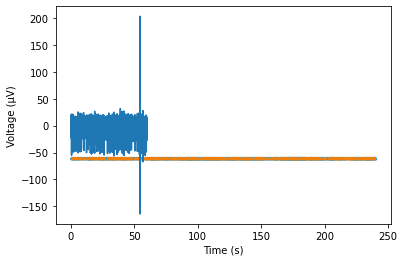

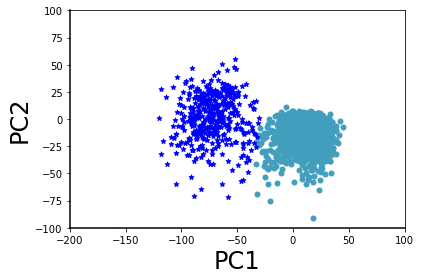

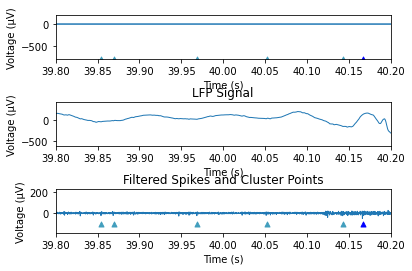

L-ratio: 3.8346169685150005e-06


In [112]:
## line 147
mu = np.mean(data, axis=0)
marker_neuron = ['o', '*', 's', 'x', 'd', 'p', '+', '.', 'v', '>']

# Plotting PCA results
fig, ax = plt.subplots()

marker_size = 15
neuron = {}
for i in range(desired_k):
    cluster_data = data[IDX == i]
    neuron[i] = (cluster_data - mu) @ coeff.T  # Transform to PCA space

    ax.scatter(-neuron[i][:, 0], -neuron[i][:, 1], marker=marker_neuron[i], color=color_cluster[i], s=marker_size, facecolors='none',linewidths=0.5)

ax.set_xlabel('PC1', fontsize=24)
ax.set_ylabel('PC2', fontsize=24)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', labelsize=16, width=2)

plt.xlim(-200, 100)
plt.ylim(-100, 100)
plt.title('PCA Clustering')
plt.show()

# Add plot for cluster indices
plt.scatter(range(len(IDX)), IDX)

# line 168

firstcluster = int(input('Please enter the first wanted cluster: '))
secondcluster = int(input('Please enter the second wanted cluster: '))

firstcluster = firstcluster - 1
secondcluster = secondcluster - 1

spike_index = np.array(detected_spikes)
IDX = np.array(IDX)

plt.figure()
hb1 = plt.subplot(2, 1, 1)
plt.plot(np.arange(0, len(rawsignal))/fsSpikes, rawsignal, linewidth=1.3)
plt.title('Spike Trace')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (μV)')
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().tick_params(axis='both', which='major', labelsize=16)

timecluster_first = [index + 30 for index, cluster in zip(spike_index, IDX) if cluster == firstcluster]
timecluster_second = [index + 30 for index, cluster in zip(spike_index, IDX) if cluster == secondcluster]

timecluster_first = np.array(timecluster_first)
timecluster_second = np.array(timecluster_second)

plt.scatter(timecluster_first/fsSpikes, -900*np.ones(len(timecluster_first)), s=5, marker='^',
            facecolors=color_cluster[firstcluster], edgecolors=color_cluster[firstcluster], linewidth=0.5)
plt.scatter(timecluster_second/fsSpikes, -900*np.ones(len(timecluster_second)), s=5, marker='^',
            facecolors=color_cluster[secondcluster], edgecolors=color_cluster[secondcluster], linewidth=0.5)

hb2 = plt.subplot(2, 1, 2, sharex=hb1)
plt.plot(np.arange(0, len(spikes))/fsSpikes, spikes, linewidth=1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)

timecluster_first = [index for index, cluster in zip(spike_index, IDX) if cluster == firstcluster]
timecluster_second = [index for index, cluster in zip(spike_index, IDX) if cluster == secondcluster]

timecluster_first = np.array(timecluster_first)
timecluster_second = np.array(timecluster_second)

plt.scatter(timecluster_first/fsSpikes, -60*np.ones(len(timecluster_first)), s=5, marker='^',
            facecolors=color_cluster[firstcluster], edgecolors=color_cluster[firstcluster], linewidth=0.5)
plt.scatter(timecluster_second/fsSpikes, -60*np.ones(len(timecluster_second)), s=5, marker='^',
            facecolors=color_cluster[secondcluster], edgecolors=color_cluster[secondcluster], linewidth=0.5)

plt.figure()
time = np.arange(1/fsSpikes, 60, 1/fsSpikes)
trace = spikes[0:60*fsSpikes-1]
plt.plot(time, trace, linewidth=1.5)
plt.ylabel('Voltage (μV)')

plt.scatter(timecluster_first/fsSpikes, -60 * np.ones(len(timecluster_first)), s=5, marker='^',
            facecolors=color_cluster[0], edgecolors=color_cluster[0])
plt.scatter(timecluster_second/fsSpikes, -60 * np.ones(len(timecluster_second)), s=5, marker='^',
            facecolors=color_cluster[3], edgecolors=color_cluster[3])

plt.xlabel('Time (s)')
plt.ylabel('Voltage (μV)')

# Plot PCA results for selected clusters
plt.figure()
plt.scatter(-neuron[firstcluster][:, 0], -neuron[firstcluster][:, 1],
            color=color_cluster[firstcluster], marker=marker_neuron[firstcluster], s=25)
plt.scatter(-neuron[secondcluster][:, 0], -neuron[secondcluster][:, 1],
            color=color_cluster[secondcluster], marker=marker_neuron[secondcluster], s=25)
plt.xlabel('PC1', fontsize=24)
plt.ylabel('PC2', fontsize=24)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.xlim(-200, 100)
plt.ylim(-100, 100)
plt.show()

# Subplots
hc = [None, None, None]

plt.figure()
# First subplot
hc[0] = plt.subplot(3, 1, 1)
plt.plot(np.arange(0, len(rawsignal))/fsSpikes, rawsignal, linewidth=1.5)
timecluster_first = spike_index[IDX == firstcluster] + 30
timecluster_second = spike_index[IDX == secondcluster] + 30
plt.scatter(timecluster_first/fsSpikes, -800*np.ones(len(timecluster_first)),
            s=25, marker='^', facecolors=color_cluster[firstcluster],
            edgecolors=color_cluster[firstcluster])
plt.scatter(timecluster_second/fsSpikes, -800*np.ones(len(timecluster_second)),
            s=25, marker='^', facecolors=color_cluster[secondcluster],
            edgecolors=color_cluster[secondcluster])
plt.xlim(39.8, 40.2)
plt.ylim(-800, 200)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (μV)')

# Second subplot
hc[1] = plt.subplot(3, 1, 2, sharex=hc[0])
plt.xlabel('Time (s)')
plt.ylabel('Voltage (μV)')
plt.title('LFP Signal')

plt.plot(np.arange(0, len(LFP))/fsSpikes, LFP, linewidth=1)
plt.ylim(-600, 400)

# Third subplot
hc[2] = plt.subplot(3, 1, 3, sharex=hc[0])
plt.plot(np.arange(0, len(spikes))/fsSpikes, spikes, linewidth=1)
plt.scatter(timecluster_first/fsSpikes, -100*np.ones(len(timecluster_first)),
            s=25, marker='^', facecolors=color_cluster[firstcluster],
            edgecolors=color_cluster[firstcluster])
plt.scatter(timecluster_second/fsSpikes, -100*np.ones(len(timecluster_second)),
            s=25, marker='^', facecolors=color_cluster[secondcluster],
            edgecolors=color_cluster[secondcluster])

plt.xlabel('Time (s)')
plt.ylabel('Voltage (μV)')
plt.title('Filtered Spikes and Cluster Points')
plt.subplots_adjust(hspace=1)
plt.show()

# Link axes
plt.setp([a.get_xticklabels() for a in hc[:-1]], visible=False)
plt.setp([a.get_yticklabels() for a in hc[:-1]], visible=False)

# Mahalanobis distance and L-ratio calculation
clusterone = neuron[firstcluster][:, :3]
clustertwo = neuron[secondcluster][:, :3]
cov_matrix = np.cov(clusterone.T)
inv_cov_matrix = np.linalg.inv(cov_matrix)

mean_cluster_one = np.mean(clusterone, axis=0)
differences = clustertwo - mean_cluster_one
md_squared = np.sum(np.dot(differences, inv_cov_matrix) * differences, axis=1)
sorted_md_squared = np.sort(md_squared)
L_ratio = np.sum(1 - chi2.cdf(sorted_md_squared, df=2)) / len(clusterone)

print("L-ratio:", L_ratio)

In [113]:
def optimize_template(cluster_data):
    # Calculate the initial template as the mean of the cluster data
    template = np.mean(cluster_data, axis=0)

    for _ in range(10):  # Iterate for a fixed number of steps
        distances = []
        for spike in cluster_data:
            # Calculate the phase space trajectory of the spike and the template
            spike_velocity = np.gradient(spike)
            template_velocity = np.gradient(template)
            spike_phase_space = np.vstack((spike, spike_velocity)).T
            template_phase_space = np.vstack((template, template_velocity)).T

            # Interpolate to make the comparison fair
            linear_interp = interp1d(np.arange(spike_phase_space.shape[0]), spike_phase_space, axis=0)
            interpolated_spike = linear_interp(np.linspace(0, spike_phase_space.shape[0]-1, template_phase_space.shape[0]))

            # Calculate the distance in the phase space
            distance = np.linalg.norm(interpolated_spike - template_phase_space, axis=1).mean()
            distances.append(distance)

        # Find the spike closest to the current template
        closest_spike_idx = np.argmin(distances)
        closest_spike = cluster_data[closest_spike_idx]

        # Update the template to be closer to the spike that is closest to the current template
        template = 0.5 * (template + closest_spike)

    return template

# Initialize a list to store the optimized templates
optimized_templates = []

# Iterate through each cluster to optimize its template
for i in range(desired_k):
    cluster_data = data[IDX == i, :]
    optimized_template = optimize_template(cluster_data)
    optimized_templates.append(optimized_template)


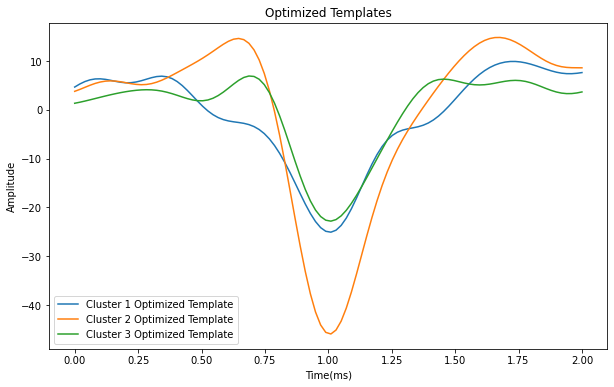

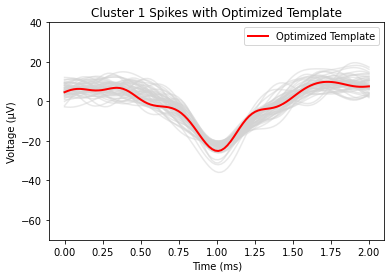

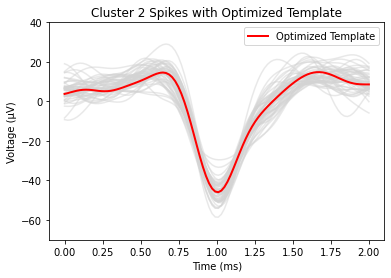

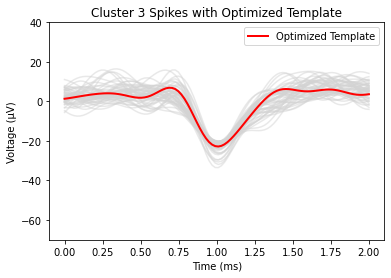

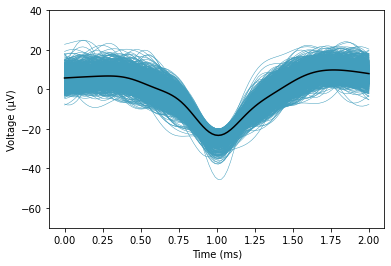

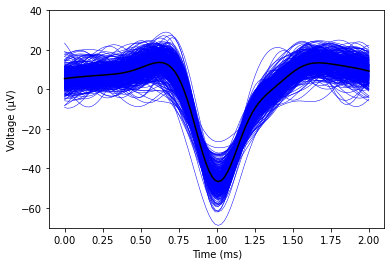

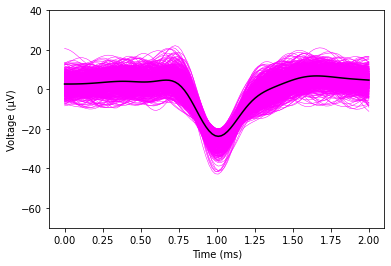

In [114]:
time = np.linspace(0, (2 * per) * 1e3 / fsSpikes, cluster_data.shape[1])
plt.figure(figsize=(10, 6))
for i, template in enumerate(optimized_templates):
    plt.plot(time, template, label=f'Cluster {i+1} Optimized Template')
plt.legend()
plt.title('Optimized Templates')
plt.xlabel('Time(ms)')
plt.ylabel('Amplitude')
plt.show()

def plot_spikes_with_template(data, IDX, cluster_number, optimized_templates, num_spikes_to_plot=50):
    """
    Plots a subset of spikes from the specified cluster along with the optimized template.

    Parameters:
    - data: ndarray, the spike waveforms.
    - IDX: ndarray, the cluster assignments for each spike.
    - cluster_number: int, the cluster to visualize.
    - optimized_templates: list of ndarrays, the optimized templates for each cluster.
    - num_spikes_to_plot: int, the number of spikes to randomly select and plot.
    """
    # Filter the data to include only spikes from the specified cluster
    cluster_spikes = data[IDX == cluster_number, :]


    # Randomly select spikes to plot to avoid overplotting
    if cluster_spikes.shape[0] > num_spikes_to_plot:
        indices = np.random.choice(cluster_spikes.shape[0], size=num_spikes_to_plot, replace=False)
    else:
        indices = np.arange(cluster_spikes.shape[0])

    selected_spikes = cluster_spikes[indices, :]

    # Plot each selected spike
    for spike in selected_spikes:
        plt.plot(time,spike, color='lightgray', alpha=0.5)  # Plot spikes in light gray

    # Plot the optimized template
    plt.plot(time,optimized_templates[cluster_number], color='red', linewidth=2, label='Optimized Template')

    plt.title(f'Cluster {cluster_number+1} Spikes with Optimized Template')
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (µV)')
    plt.ylim([-70, 40])
    plt.legend()
    plt.show()

plot_spikes_with_template(data, IDX, 0, optimized_templates)
plot_spikes_with_template(data, IDX, 1, optimized_templates)
plot_spikes_with_template(data, IDX, 2, optimized_templates)


for i in range(desired_k):
    plt.figure()
    # Select data for the current cluster
    cluster_data = data[IDX == i, :]
    # Plot each waveform in the cluster
    for waveform in cluster_data:
        plt.plot(time, waveform, color=color_cluster[i], linewidth=0.5)

    # Calculate the mean waveform for the current cluster
    meanofdata = np.mean(cluster_data, axis=0)
    # Plot the mean waveform
    plt.plot(time, meanofdata, 'k', linewidth=1.5)  # 'k' is for black color

    # plt.title(f'Sorted neuron signals cluster={i+1}')  # i+1 to convert from 0-based to 1-based indexing
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (µV)')
    plt.ylim([-70, 40])

plt.show()

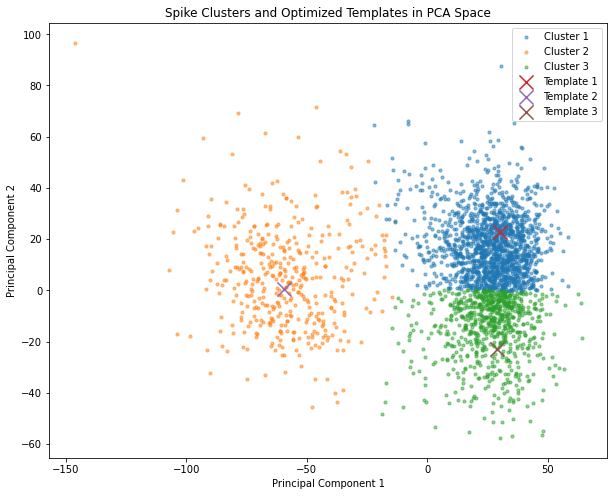

L-ratio: 5.1109530592524615e-06


In [115]:
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

# Stack optimized templates into a matrix
optimized_templates_matrix = np.stack(optimized_templates)

# Perform PCA on the optimized templates
pca = PCA(n_components=3)  # We are interested in the first three components for visualization
pca.fit(optimized_templates_matrix)

# Project each optimized template onto the first two principal components
templates_pca = pca.transform(optimized_templates_matrix)

data_pca = pca.transform(data)

# Calculate distances between each spike in PCA space and each template PCA representation
distances = cdist(data_pca, templates_pca)

# Assign each spike to the nearest template based on the smallest distance
cluster_labels = np.argmin(distances, axis=1)

plt.figure(figsize=(10, 8))

# Create a scatter plot for each cluster with a different color
for cluster_id in np.unique(cluster_labels):
    cluster_points = data_pca[cluster_labels == cluster_id]
    plt.scatter(-cluster_points[:, 0], -cluster_points[:, 1], alpha=0.5, s=10, label=f'Cluster {cluster_id+1}')

# Highlight the position of each optimized template in the PCA space with a larger, distinct marker
for i, template_pca in enumerate(templates_pca):
    plt.scatter(-template_pca[0], -template_pca[1], marker='x', s=200, label=f'Template {i+1}')

plt.title('Spike Clusters and Optimized Templates in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


clusterone = data_pca[cluster_labels==0][:, :3]
clustertwo = data_pca[cluster_labels==1][:, :3]


cov_matrix = np.cov(clusterone.T)
inv_cov_matrix = np.linalg.inv(cov_matrix)

mean_cluster_one = np.mean(clusterone, axis=0)
differences = clustertwo - mean_cluster_one
md_squared = np.sum(np.dot(differences, inv_cov_matrix) * differences, axis=1)
sorted_md_squared = np.sort(md_squared)
L_ratio = np.sum(1 - chi2.cdf(sorted_md_squared, df=2)) / len(clusterone)


print("L-ratio:", L_ratio)



In [116]:


def calculate_isolation_distance(cluster_data, other_data, num_components=3):
    # Combine cluster data and other data
    combined_data = np.vstack((cluster_data, other_data))
    
    # Apply PCA to reduce dimensionality for computational efficiency
    pca = PCA(n_components=num_components)
    reduced_data = pca.fit_transform(combined_data)
    
    # Calculate the centroid of the cluster
    cluster_centroid = np.mean(pca.transform(cluster_data), axis=0)
    
    # Calculate Mahalanobis distances of all points to the cluster centroid
    cov_matrix = np.cov(reduced_data.T)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    distances = cdist([cluster_centroid], reduced_data, 'mahalanobis', VI=inv_cov_matrix).flatten()
    
    # Sort distances and find the distance at which the smallest 100*N points fall within
    sorted_distances = np.sort(distances)
    isolation_distance = sorted_distances[len(cluster_data)-1]

    return isolation_distance


cluster_id = 0
cluster_data = data[IDX == cluster_id, :]
other_data = data[IDX != cluster_id,:]

cluster_data_new = data_pca[cluster_labels==cluster_id][:, :3]
other_data_new = data_pca[cluster_labels!=cluster_id][:, :3]

isolation_distance_original = calculate_isolation_distance(cluster_data, other_data)
isolation_distance = calculate_isolation_distance(cluster_data_new, other_data_new)
print("Isolation Distance for cluster {}: {}".format(cluster_id+1, isolation_distance_original))
print("Isolation Distance for new cluster {}: {}".format(cluster_id+1, isolation_distance))

Isolation Distance for cluster 1: 1.4624717011551875
Isolation Distance for new cluster 1: 1.550541492439331


In [117]:
from sklearn.metrics import silhouette_score

initial_silhouette_score = silhouette_score(data, IDX)

print(f"Initial Silhouette Score: {initial_silhouette_score:.2f}")



optimized_silhouette_score = silhouette_score(data_pca, cluster_labels)

print(f"Optimized Silhouette Score: {optimized_silhouette_score:.2f}")

Initial Silhouette Score: 0.19
Optimized Silhouette Score: 0.42
